### Problem Statement
Develop a scalable customer segmentation system for the online learning platforms using behavioral, financial, geographic, and acquisition data to enable targeted marketing, personalized learning experiences, and optimized revenue generation.

### Importing Required Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

### Configurations

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

sns.set(style="whitegrid", font_scale=1.1, palette="muted")

In [4]:
import warnings

warnings.filterwarnings("ignore")

### Data Loading

In [5]:
df = pd.read_csv("/content/customer_segmentation_data.csv")

In [6]:
df.head()

,minutes_watched,CLV,region,channel
0,3197.00,205.42,2,4
1,63.00,149.99,0,1
2,605.00,119.00,2,2
3,20.00,240.00,2,4
4,245.00,184.36,1,4


### Initial Inspection

#### Shape & Structure

In [33]:
print(f"Shape : {df.shape[0]:,} rows × {df.shape[1]} columns")

Shape : 3,834 rows × 4 columns


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


#### Missing Values

In [34]:
print(f"\nMissing Values:\n{df.isnull().sum()}")


Missing Values:
minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64


In [35]:
print(f"\nMissing % :\n{(df.isnull().sum() / len(df) * 100).round(2)}")


Missing % :
minutes_watched   2.84
CLV               0.00
region            0.00
channel           0.00
dtype: float64


#### Duplicate Records

In [36]:
n_duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows : {n_duplicates}")


Duplicate Rows : 43


### Descriptive Statistics

#### Numerical Features

In [ ]:
df[["minutes_watched", "CLV"]].describe().T

,count,mean,std,min,25%,50%,75%,max
minutes_watched,3725.00,1972.09,7401.69,0.00,159.00,512.00,1521.00,288508.00
CLV,3834.00,118.38,70.47,0.00,62.58,119.00,149.99,626.40


**'minutes_watched'**,  the mean (1,972 min) is nearly 4× the median (512 min), driven by a small group of power users reaching up to 288,508 minutes.

In [10]:
df[['minutes_watched', 'CLV']].skew().round(2)

,0
minutes_watched,20.51
CLV,1.35


**'minutes_watched'**, Extreme Right Skew (Skewness: 20.5), this variable must be log-transformed before clustering — raw values would cause K-Means to collapse all clusters around outliers.

**Zero-Value** flags, meaningful edge cases

In [19]:
n_clv_zero = (df['CLV'] == 0).sum()
print(f"CLV = 0 : {n_clv_zero} (potential free-tier users)")

CLV = 0 : 10 (potential free-tier users)


In [21]:
n_watch_zero = (df['minutes_watched'] == 0).sum()
print(f"minutes_watched = 0 : {n_watch_zero}  (zero-engagement / dormant users)")

minutes_watched = 0 : 39  (zero-engagement / dormant users)


#### Categorical Features

In [41]:
REGION_MAP  = {0: 'US/CA/UK/AU', 1: 'W. Europe', 2: 'Rest of World'}

In [45]:
region_dist = df["region"].value_counts().sort_index().rename(index=REGION_MAP)
print(f"\nRegion Distribution:\n{region_dist}")
print(f"\nRegion % :\n{(region_dist / len(df) * 100).round(1)}")


Region Distribution:
region
US/CA/UK/AU      1366
W. Europe         461
Rest of World    2007
Name: count, dtype: int64

Region % :
region
US/CA/UK/AU     35.60
W. Europe       12.00
Rest of World   52.30
Name: count, dtype: float64


**Region — Heavy Concentration in Region 2 (Rest of World)**
Region 2 accounts for 52% of students, Region 0 (EN-speaking West) at 36%, Region 1 (W. Europe) at 12%. This distribution matters for marketing localization.

In [46]:
CHANNEL_MAP = {1: 'Google', 2: 'Facebook', 3: 'YouTube', 4: 'LinkedIn',
               5: 'Twitter', 6: 'Instagram', 7: 'Friend', 8: 'Other'}

In [48]:
channel_dist = df["channel"].value_counts().sort_index().rename(index=CHANNEL_MAP)
print(f"\nChannel Distribution:\n{channel_dist}")
print(f"\nChannel % :\n{(channel_dist / len(df) * 100).round(1)}")


Channel Distribution:
channel
Google        671
Facebook      306
YouTube      1094
LinkedIn      650
Twitter        58
Instagram     289
Friend        478
Other         288
Name: count, dtype: int64

Channel % :
channel
Google      17.50
Facebook     8.00
YouTube     28.50
LinkedIn    17.00
Twitter      1.50
Instagram    7.50
Friend      12.50
Other        7.50
Name: count, dtype: float64


**Channel — YouTube Dominates, Twitter is Negligible**
YouTube (Channel 3) is the top acquisition channel at 29% of students. Twitter (Channel 5) delivers only 58 students — statistically unreliable for segment-level strategy. LinkedIn and Google are the next strongest.

### UniVariate Analysis

In [53]:
COLORS = {
    'primary': '#2E4057',
    'accent1': '#048A81',
    'accent2': '#E76F51',
    'accent3': '#F4A261',
    'light'  : '#F0F4F8',
    'grid'   : '#E0E0E0'
}
#plt.figure(figsize=(20, 22), facecolor='white')

<Figure size 2000x2200 with 0 Axes>

<Figure size 2000x2200 with 0 Axes>

#### Minutes Watched

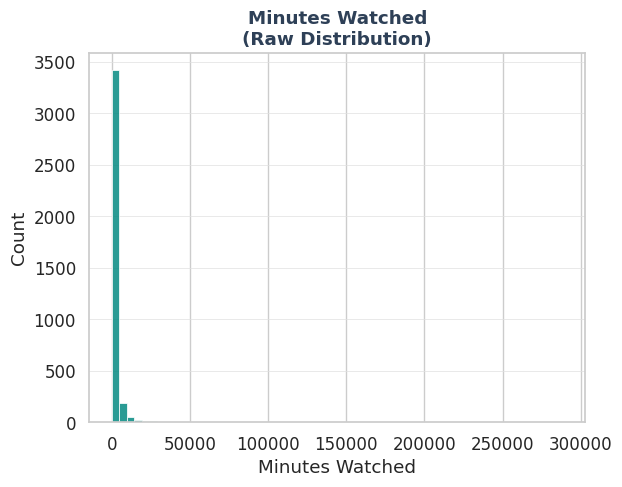

In [62]:
sns.histplot(df['minutes_watched'], bins=60, color=COLORS['accent1'],
         edgecolor='white', alpha=0.85)
plt.title('Minutes Watched\n(Raw Distribution)', fontweight='bold', color=COLORS['primary'])
plt.xlabel('Minutes Watched')
plt.ylabel('Count')
#plt.facecolor(COLORS['light'])
plt.grid(axis='y', color=COLORS['grid'], linewidth=0.5)
#plt.spines[['top', 'right']].set_visible(False)

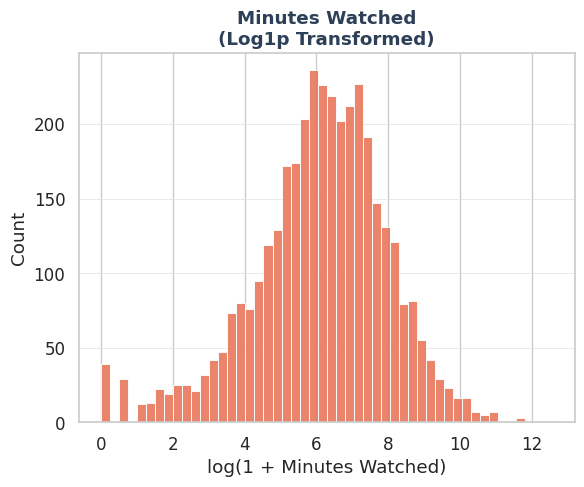

In [63]:
sns.histplot(np.log1p(df['minutes_watched']), bins=50, color=COLORS['accent2'],
         edgecolor='white', alpha=0.85)
plt.title('Minutes Watched\n(Log1p Transformed)', fontweight='bold', color=COLORS['primary'])
plt.xlabel('log(1 + Minutes Watched)')
plt.ylabel('Count')
#plt.set_facecolor(COLORS['light'])
plt.grid(axis='y', color=COLORS['grid'], linewidth=0.5)
#plt.spines[['top', 'right']].set_visible(False)

#### CLV

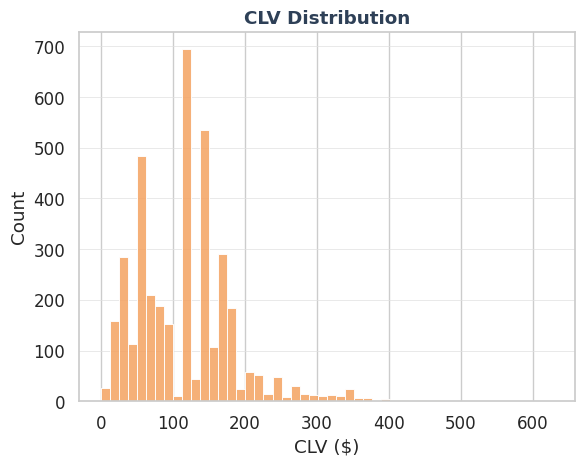

In [64]:
sns.histplot(df['CLV'], bins=50, color=COLORS['accent3'], edgecolor='white', alpha=0.85)
plt.title('CLV Distribution', fontweight='bold', color=COLORS['primary'])
plt.xlabel('CLV ($)')
plt.ylabel('Count')
#plt.set_facecolor(COLORS['light'])
plt.grid(axis='y', color=COLORS['grid'], linewidth=0.5)
#plt.spines[['top', 'right']].set_visible(False)

#### Region

Text(0.5, 1.0, 'Region Distribution')

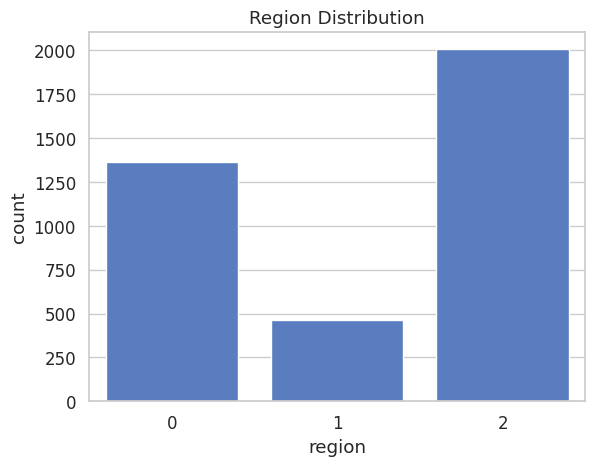

In [24]:
sns.countplot(data=df, x='region')
plt.title("Region Distribution")

#### Channel

Text(0.5, 1.0, 'Channel Distribution')

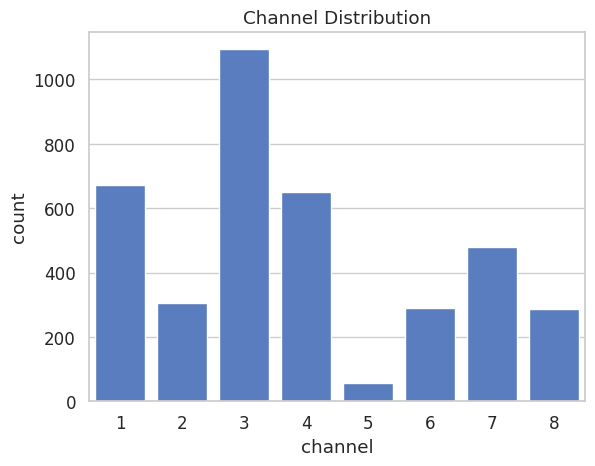

In [25]:
sns.countplot(data=df, x='channel')
plt.title("Channel Distribution")

### BiVariate Analysis

#### Engagement vs Revenue

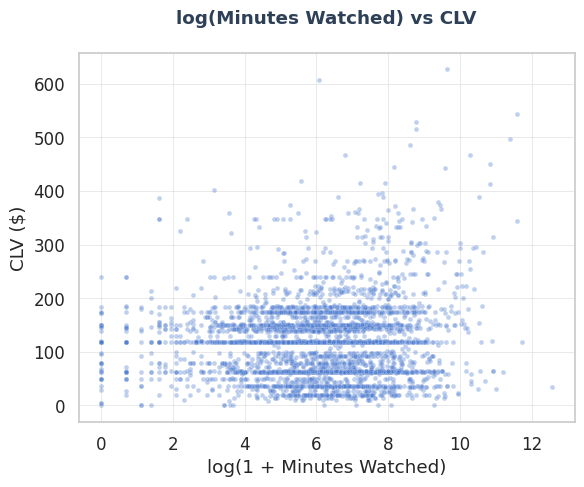

In [75]:
sns.scatterplot(x=np.log1p(df['minutes_watched']), y=df['CLV'],
                alpha=0.35, s=12)
plt.title('log(Minutes Watched) vs CLV\n',
              fontweight='bold', color=COLORS['primary'])
plt.xlabel('log(1 + Minutes Watched)')
plt.ylabel('CLV ($)')
plt.grid(color=COLORS['grid'], linewidth=0.5)

#### Region Performance

In [49]:
region_stats = df.groupby('region').agg(
    n_students=('CLV', 'count'),
    mean_clv=('CLV', 'mean'),
    median_clv=('CLV', 'median'),
    mean_minutes=('minutes_watched', 'mean'),
    median_minutes=('minutes_watched', 'median')
).rename(index=REGION_MAP).round(2)
print(f"\nRegion Performance Summary:\n{region_stats}")


Region Performance Summary:
               n_students  mean_clv  median_clv  mean_minutes  median_minutes
region                                                                       
US/CA/UK/AU          1366    136.62      122.71       1611.45          353.00
W. Europe             461    158.14      145.74       1875.96          662.50
Rest of World        2007     96.84       78.87       2236.08          615.00


In [79]:
palette = [COLORS['accent1'], COLORS['accent2'], COLORS['accent3']]

#### Students by Region

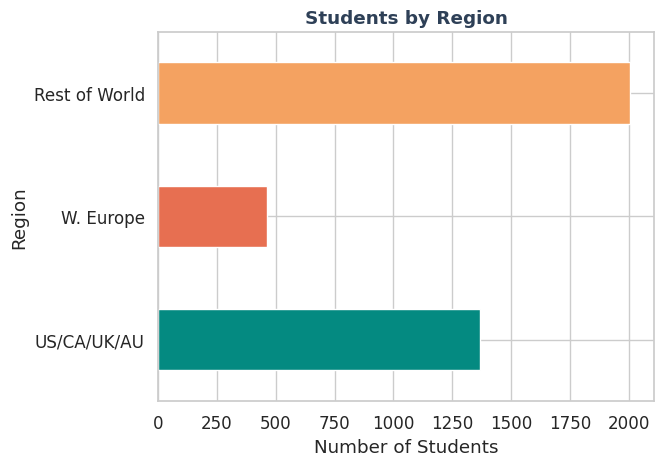

In [106]:
region_stats["n_students"].plot(kind="barh", edgecolor='white', color=palette)
plt.xlabel("Number of Students")
plt.ylabel("Region")
plt.title('Students by Region', fontweight='bold', color=COLORS['primary'])
plt.show()

#### Channel Performance

In [50]:
channel_stats = df.groupby('channel').agg(
    n_students=('CLV', 'count'),
    mean_CLV=('CLV', 'mean'),
    median_CLV=('CLV', 'median'),
    mean_minutes=('minutes_watched', 'mean'),
    median_minutes=('minutes_watched', 'median')
).rename(index=CHANNEL_MAP).round(2)

print(f"\nChannel Performance Summary:\n{channel_stats}")


Channel Performance Summary:
           n_students  mean_CLV  median_CLV  mean_minutes  median_minutes
channel                                                                  
Google            671    121.15      119.00       1857.42          534.50
Facebook          306    108.26      119.00       2861.15          574.50
YouTube          1094    129.05      119.35       2051.67          467.00
LinkedIn          650    107.37      119.00       1629.49          520.50
Twitter            58     93.15       62.58       1002.61          360.00
Instagram         289    115.18      119.00       1385.63          540.00
Friend            478    113.65      118.66       2049.06          583.00
Other             288    123.19      119.00       2414.70          453.50


#### Students by Acquisition Channel

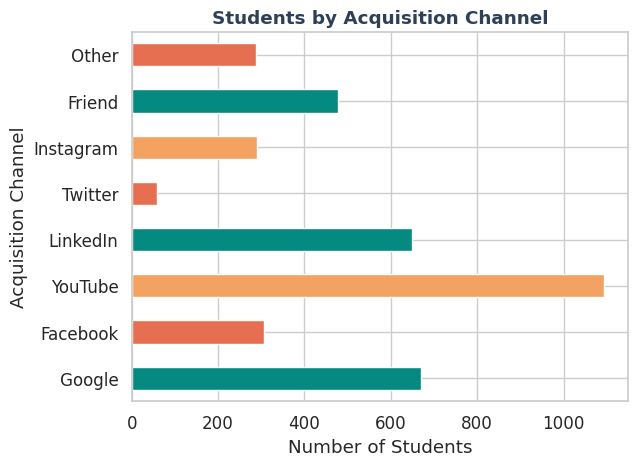

In [107]:
channel_stats["n_students"].plot(kind="barh", edgecolor='white', color=palette)
plt.ylabel("Acquisition Channel")
plt.xlabel("Number of Students")
plt.title('Students by Acquisition Channel', fontweight='bold', color=COLORS['primary'])
plt.show()

In [93]:
REGION_MAP

{0: 'US/CA/UK/AU', 1: 'W. Europe', 2: 'Rest of World'}

#### Minutes Watched by Region

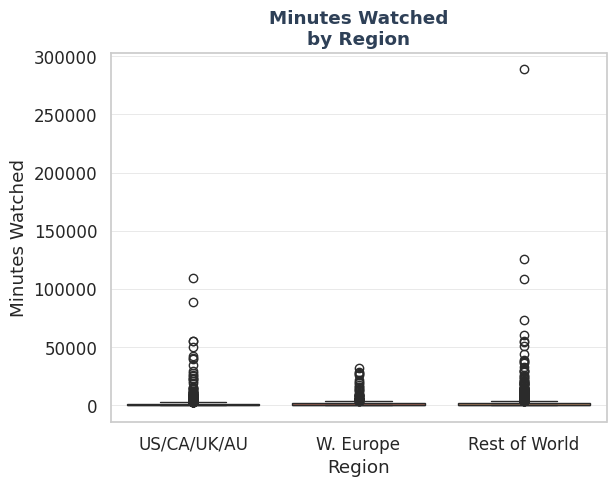

In [104]:
sns.boxplot(x=df['region'], y=df['minutes_watched'], palette=palette)
new_labels = ["US/CA/UK/AU", "W. Europe", "Rest of World"]
plt.xticks(ticks=range(df['region'].nunique()), labels=new_labels)
plt.title('Minutes Watched\nby Region', fontweight='bold', color=COLORS['primary'])
plt.xlabel('Region')
plt.ylabel('Minutes Watched')
plt.grid(axis='y', color=COLORS['grid'], linewidth=0.5)
plt.show()

#### CLV by Region

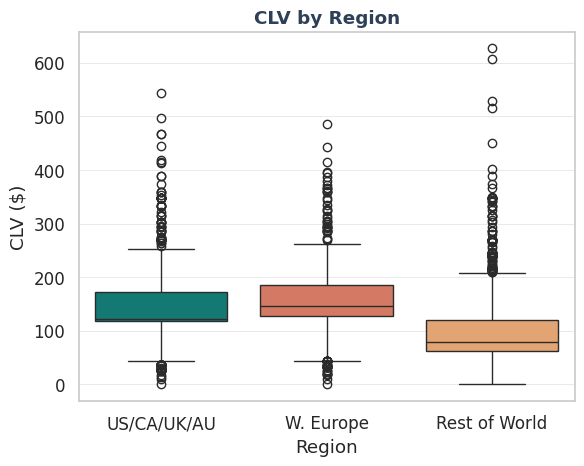

In [102]:
sns.boxplot(x=df['region'], y=df['CLV'], palette=palette)
new_labels = ["US/CA/UK/AU", "W. Europe", "Rest of World"]
plt.xticks(ticks=range(df['region'].nunique()), labels=new_labels)
plt.title('CLV by Region', fontweight='bold', color=COLORS['primary'])
plt.xlabel('Region')
plt.ylabel('CLV ($)')
plt.grid(axis='y', color=COLORS['grid'], linewidth=0.5)
plt.show()

#### Correlation

<Axes: >

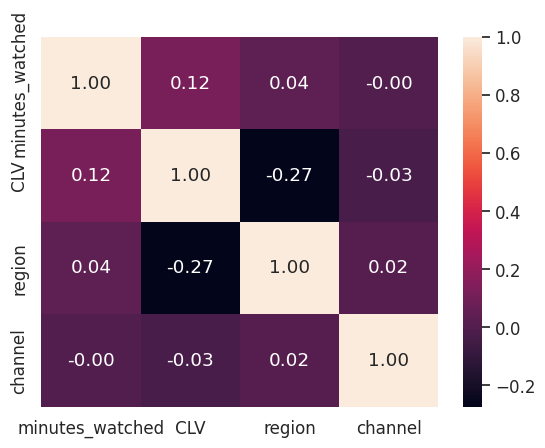

In [27]:
sns.heatmap(df.corr(), annot=True, fmt='.2f')

### Outlier Detection

Text(0.5, 1.0, 'Minutes Watched Outliers')

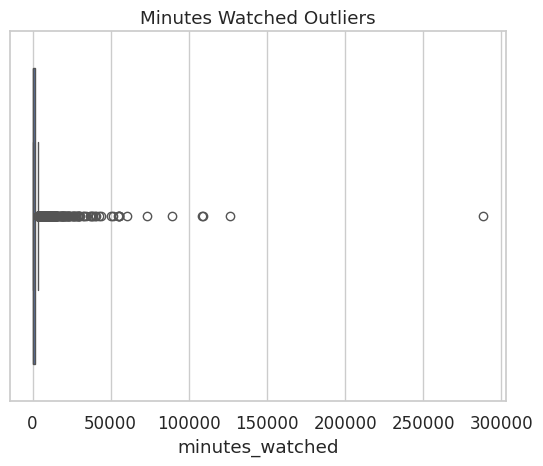

In [28]:
sns.boxplot(data=df, x='minutes_watched')
plt.title("Minutes Watched Outliers")

Text(0.5, 1.0, 'CLV Outliers')

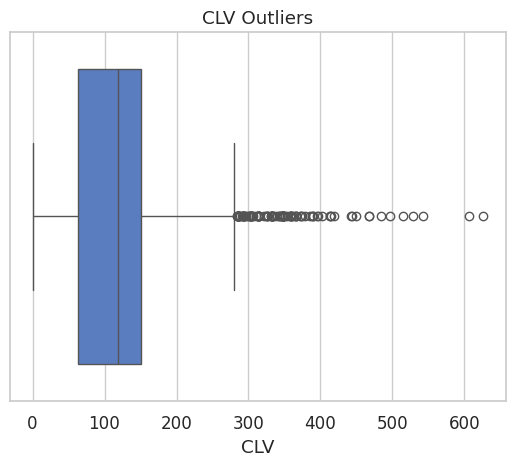

In [29]:
sns.boxplot(data=df, x='CLV')
plt.title("CLV Outliers")

#### Z-Score Method

In [30]:
z_scores = np.abs(stats.zscore(df[['minutes_watched', 'CLV']]))
outliers = (z_scores > 3).any(axis=1)
df[outliers].shape[0]

72

#### IQR Method

In [40]:
print(f"\nOutlier Analysis (IQR Method):")
for col in ['minutes_watched', 'CLV']:
    Q1  = df[col].quantile(0.25)
    Q3  = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_out = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    print(f"  {col:<16} | Outliers: {n_out:>4} ({n_out/len(df)*100:.1f}%) "
          f"| Bounds: [{lower:.1f}, {upper:.1f}] | Max: {df[col].max():.1f}")


Outlier Analysis (IQR Method):
  minutes_watched  | Outliers:  414 (10.8%) | Bounds: [-1884.0, 3564.0] | Max: 288508.0
  CLV              | Outliers:  120 (3.1%) | Bounds: [-68.5, 281.1] | Max: 626.4


### Data Cleaning

In [108]:
df_cleaned = df.copy()
print(f"Initial shape : {df_cleaned.shape}")

Initial shape : (3834, 4)


#### Drop exact duplicates

In [109]:
df_cleaned = df_cleaned.drop_duplicates()
print(f"After drop_duplicates : {df_cleaned.shape}")

After drop_duplicates : (3791, 4)


#### Impute missing minutes_watched with median

In [111]:
median_mw = df_cleaned['minutes_watched'].median()
df_cleaned['minutes_watched'] = df_cleaned['minutes_watched'].fillna(median_mw)
print(f"Imputed minutes_watched NaN : {df['minutes_watched'].isnull().sum()} → 0 "
      f"(median = {median_mw})")

Imputed minutes_watched NaN : 109 → 0 (median = 516.5)


#### Flag edge-case rows (retain — do NOT drop)

CLV=0     → free-tier or refunded users; a valid and actionable segment \
watched=0 → dormant / zero-engagement users; important for win-back campaigns

In [117]:
df_cleaned['is_free_user'] = (df_cleaned['CLV'] == 0).astype(int)
df_cleaned['is_zero_engagement'] = (df_cleaned['minutes_watched'] == 0).astype(int)
print(f"Flagged free users (CLV=0)                       : {df_cleaned['is_free_user'].sum()}")
print(f"Flagged zero engagement (minutes_watched = 0)    : {df_cleaned['is_zero_engagement'].sum()}")

Flagged free users (CLV=0)                       : 10
Flagged zero engagement (minutes_watched = 0)    : 35


### Final Dataset Validation

In [118]:
print(f"\nFinal clean shape : {df_cleaned.shape}")
print(f"Remaining nulls   :\n{df_cleaned.isnull().sum()}")


Final clean shape : (3791, 6)
Remaining nulls   :
minutes_watched       0
CLV                   0
region                0
channel               0
is_free_user          0
is_zero_engagement    0
dtype: int64


#### Save cleaned dataset

In [119]:
df_cleaned.to_csv('customer_segmentation_clean.csv', index=False)
print(f"\nCleaned dataset saved")


Cleaned dataset saved
